# Quickstart: Min pattern analysis

**For a first impression of the analysis routines provided, please refer to the notebooks "DEMO_Min_global_analysis.ipynb" and "DEMO_Min_local_analysis.ipynb"!**<br>
<br>This notebook allows to load in a single Min pattern acquisition stack and perform quick pattern analysis. Data has to be provided as tif-file, containing acquisitions from one channel (e.g. MinE or MinD) only. Note that image cleaning of the stack is not included here and needs be performed before analysis. Insufficient pre-processing can lead to erroneous results.<br>
Cells in this notebook need to be executed sequentially. To start up the analysis provided within this notebook, first set the file path and parameters below. Next, click the ▷▷ symbol above (*Restart the kernel, then re-run the whole notebook*) and hit "Restart". After that, the notebook will take a few moments to set up, and figures/plots will appear one by one.<br>
<br>
To perform analysis on your own file, click the "Upload Files" (🡅) button just below the menu bar and add your file. After your file appears in the folder menu to the left, set the variable *stack_path* in the following way to refer to a file in the binder's home directory:
```
stack_path = Path().cwd() / "my_pattern.tif"
```
Note: If you are viewing this in a Jupyter binder, your file is *not* going to be visible to other users.

## Setup
Import of standard modules, the used flow field analysis method (Horn-Schunck) and assisting custom-made modules. Needs to be executed at least once to ensure correct functionality (see instructions above).

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

from min_analysis_tools import correlation_tools
from min_analysis_tools.get_auto_halfspan import get_auto_halfspan
from min_analysis_tools.local_velocity_analysis import local_velocity_analysis

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

## File selection and input parameters
Please select your file path and input parameters here.

Input file path:

In [2]:
stack_path = Path().cwd() / "example_data" / "paper_example.tif"

Saving images:

In [3]:
save = False  # 'save' set to True -> images saved to folder 'save_output'
save_dpi = 300  # image quality
cm = 1 / 2.54  # centimeters in inches (for matplotlib figure size)
single_fig_size = (8 * cm, 8 * cm)  # small figures
double_fig_size = (16 * cm, 8 * cm)  # broad figures

General / display paramters:

In [4]:
frames_to_analyse = 10  # analyse first .. frames (global/spatial and local analysis)

Stack information (set both to "None" to work with pixels and frames only):

In [5]:
nmperpix = 594  # nanometer per pixel (assuming aspect ratio = 1)
frpermin = 4  # frames per minute

Temporal autocorrelation analysis parameters:

In [6]:
reps_per_kymostack = 5  # pick ... kymographs around middle
kymoband = 0.8  # analyse middle ... part of image

Local analysis parameters:

In [7]:
halfspan = None  # set to "None" to use automatic halfspan (recommended!)
sampling_width = 0.25  # in pixel units
edge = 30  # outer edge (+/-) for velocity wheel and velocity histogram
bins_wheel = 50  # number of horizontal/vertical bins for histogram wheels
binwidth_sum = 1  # binwidth for velocity magnitude histogram (in pixel/frame)
kernel_size_general = 20  # kernel for first smoothing step (smaller)
kernel_size_flow = 35  # building smoothening kernel needed for flow analysis (larger)

## Preparation

Current file: paper_example, size: 512 pixels x 512 pixels x 20 frames


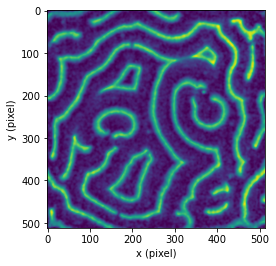

In [8]:
# Load stack
Min_st = io.imread(stack_path)
stackname = stack_path.stem
nt, ny, nx = np.shape(Min_st)
print(f"Current file: {stackname}, size: {nx} pixels x {ny} pixels x {nt} frames")

fig, ax = plt.subplots()
ax.imshow(Min_st[0, :, :])
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")

if save:
    fig.set_size_inches(single_fig_size)
    fig.tight_layout()
    fig.savefig(f"save_output/{stackname}_image.png", dpi=save_dpi)
plt.show()

## Global analysis: Spatial autocorrelation
Note: Confirm by visual inspection that the identified local maximum (magenta dashed line) is located at where you expect it to be in the plot. If not, a closer inspection of the image stack or an adaptation of the analysis routine might be required.

Analysing 10 frames


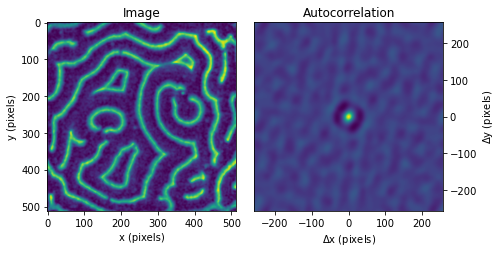

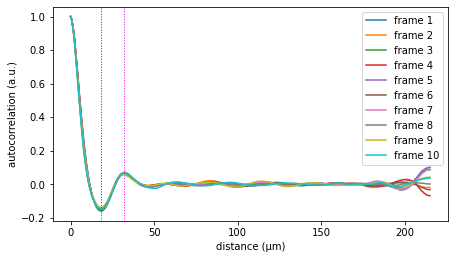

mean position of first valley: 18.30 µm
mean position of first peak (!): 32.19 µm


In [9]:
# Recognize unit
if nmperpix is None:
    unit = "pixels"
else:
    unit = "µm"

# Autocorrelation --> obtain array of autocorrelation matrixes for analyzed frames
(
    crmx_storage,
    fig,
    ax_corr,
    ax_orig,
) = correlation_tools.get_spatial_correlation_matrixes(Min_st, frames_to_analyse)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(
        f"save_output/{stackname}_global_spatial_autocorrelation_.png", dpi=save_dpi
    )
plt.show()

# Calculate radially averaged profile traces
# and analyze them with respect to first min and max, mean-average
(
    first_min_pos,
    first_min_val,
    first_max_pos,
    first_max_val,
    fig,
    ax,
) = correlation_tools.analyze_radial_profiles(crmx_storage, nmperpix)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(
        f"save_output/{stackname}_global_spatial_radialprofiles_.png", dpi=save_dpi
    )
plt.show()

# Determine halfspan for local analysis later
if halfspan is None:
    halfspan = get_auto_halfspan(Min_st, frames_to_analyse, verbose=False)

# Print averaged values
print(f"mean position of first valley: {np.nanmean(first_min_pos):.02f} {unit}")
print(f"mean position of first peak (!): {np.nanmean(first_max_pos):.02f} {unit}")

## Global analysis: Temporal autocorrelation
Note: Confirm by visual inspection that the identified local maximum (magenta dashed line) is located at where you expect it to be in the plot. If not, a closer inspection of the image stack or an adaptation of the analysis routine might be required.

Analyzing t-x slices for y = [ 51 153 256 358 460]


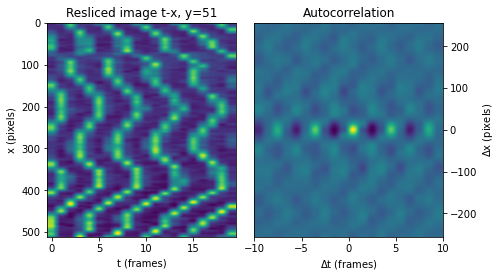

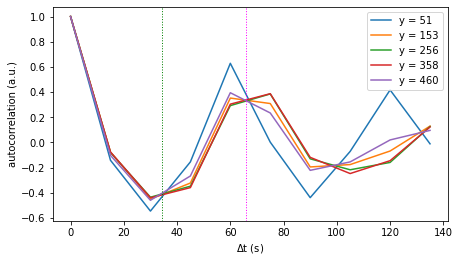

Analyzing t-y slices for x = [ 51 153 256 358 460]


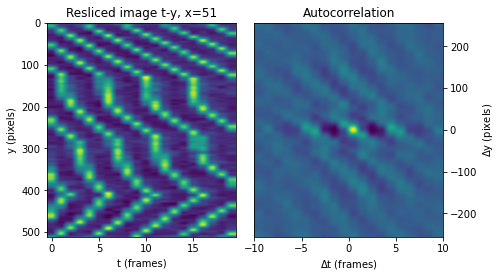

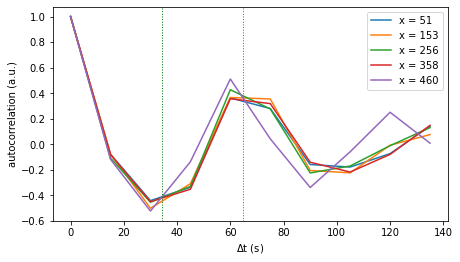

mean position of first valley: 34.29 s
mean position of first peak (!): 65.40 s


In [10]:
## Recognize unit
if frpermin is None:
    unit = "frames"
else:
    unit = "s"

## Reslice image stack
Min_shift_tx = np.moveaxis(Min_st, 0, -1)  # creates t-x resliced frames
Min_shift_yt = np.moveaxis(Min_st, -1, 0)  # creates y-t resliced frames
ff, rr, cc = np.shape(Min_shift_yt)
Min_shift_ty = np.empty((ff, cc, rr))
for frame in range(ff):  # transpose images to create t-y resliced frames
    Min_shift_ty[frame, :, :] = np.transpose(Min_shift_yt[frame, :, :])

## Perform analysis for t-x slices (fixed y)
(
    crmx_storage_x,
    slices2analyze_x,
    fig,
    ax_corr,
    ax_orig,
) = correlation_tools.get_temporal_correlation_matrixes(
    Min_shift_tx,
    "x",
    kymoband,
    reps_per_kymostack,
    demo=True,
)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(
        f"save_output/{stackname}_global_temporal_autocorrelation_tx.png", dpi=save_dpi
    )
plt.show()

# Analyse selected traces with respect to first min and max
(
    first_min_pos_x,
    first_min_val_x,
    first_max_pos_x,
    first_max_val_x,
    fig,
    ax,
) = correlation_tools.analyze_temporal_profiles(
    "x", crmx_storage_x, slices2analyze_x, frpermin, demo=True
)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(
        f"save_output/{stackname}_global_temporal_autocorr_traces_tx.png", dpi=save_dpi
    )
plt.show()

## Perform analysis for t-y slices (fixed x)
(
    crmx_storage_y,
    slices2analyze_y,
    fig,
    ax_corr,
    ax_orig,
) = correlation_tools.get_temporal_correlation_matrixes(
    Min_shift_ty,
    "y",
    kymoband,
    reps_per_kymostack,
    demo=True,
)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(
        f"save_output/{stackname}_global_temporal_autocorrelation_ty.png", dpi=save_dpi
    )
plt.show()

# Analyse selected traces with respect to first min and max
(
    first_min_pos_y,
    first_min_val_y,
    first_max_pos_y,
    first_max_val_y,
    fig,
    ax,
) = correlation_tools.analyze_temporal_profiles(
    "y", crmx_storage_y, slices2analyze_y, frpermin, demo=True
)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(
        f"save_output/{stackname}_global_temporal_autocorr_traces_ty.png", dpi=save_dpi
    )
plt.show()

## Print averaged values
print(
    f"mean position of first valley: {np.nanmean(np.append(first_min_pos_x, first_min_pos_y)):.02f} {unit}"
)
print(
    f"mean position of first peak (!): {np.nanmean(np.append(first_max_pos_x, first_max_pos_y)):.02f} {unit}"
)

## Local analysis: Wave propagation velocity
Notes:
- Depending on file size and number of frames to analyse, this computation may take a while to finish.
- Confirm by visual inspection that the 2D histogram is wide enough to contain your velocity distribution. If not, adapt the local analysis parameters above.
- If there is a large peak in the center (around 0 pixels/frame), choosing a larger general smoothing kernel might be necessary.

Used halfspan: 30 pixels
Analysing 10 frames
peak velocity magnitude: 11.00 pixels/frame
FWHM velocity magnitude: 4.00 pixels/frame
Median velocity magnitude: 12.04 pixels/frame


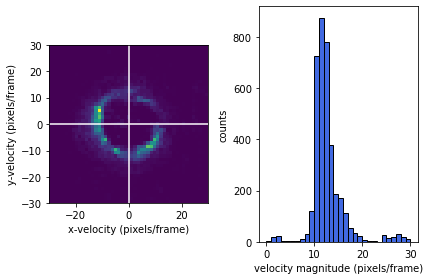

Median velocity magnitude: 487 nm/s


In [11]:
print(f"Used halfspan: {halfspan} pixels")
(
    velocities,
    forward_wavevector_x,
    forward_wavevector_y,
    all_wheels,
    crests_x,
    crests_y,
    framenr,
    max_x1,
    max_y1,
    max_x2,
    max_y2,
    fig,
    ax_wheel,
    ax_sum,
) = local_velocity_analysis(
    Min_st,
    frames_to_analyse,
    halfspan,
    sampling_width,
    edge,
    bins_wheel,
    binwidth_sum,
    kernel_size_general,
    kernel_size_flow,
    look_ahead=1,  # for ridge advancement search: 1=forward, -1 is backward
    demo=True,
)
if save:
    fig.set_size_inches(double_fig_size)
    fig.tight_layout()
    fig.savefig(f"save_output/{stackname}_local_velocity.png", dpi=save_dpi)
plt.show()

if nmperpix is not None and frpermin is not None:
    unit = "nm/s"
    factor = (nmperpix) / (60 / frpermin)
    print(f"Median velocity magnitude: {np.nanmedian(velocities * factor):.0f} nm/s")